In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/content/drive/MyDrive/cs231n/2022/assignment1'
assert FOLDERNAME is not None, '/content/drive/MyDrive/cs231n/2022/assignment1'

In [ ]:
# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/cs231n/2022/assignment1')

In [5]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd '/Users/junghwankim/Desktop/cs231n/2022/assignment1/cs231n/datasets'
!bash get_datasets.sh
%cd '/Users/junghwankim/Desktop/cs231n/2022/assignment1'

/Users/junghwankim/Desktop/cs231n/2022/assignment1/cs231n/datasets
--2022-10-05 11:56:34--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: 'cifar-10-python.tar.gz'

cifar-10-python.tar 100%[===================>] 162.60M  4.59MB/s    in 56s     

2022-10-05 11:57:32 (2.88 MB/s) - 'cifar-10-python.tar.gz' saved [170498071/170498071]

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1
/Users/junghwankim/Desktop/cs231n/2022/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights
- SVM의 loss function을 fully-vectorized로 구현하기
- analytic gradient를 fully-vectorized expression으로 구현
- numerical gradient를 통해 구현 확인해보기
- validation set을 통해 lr과 regularization을 tunning
- SGD로 loss function optimize
- learned weights visualize해보기


In [6]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [7]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


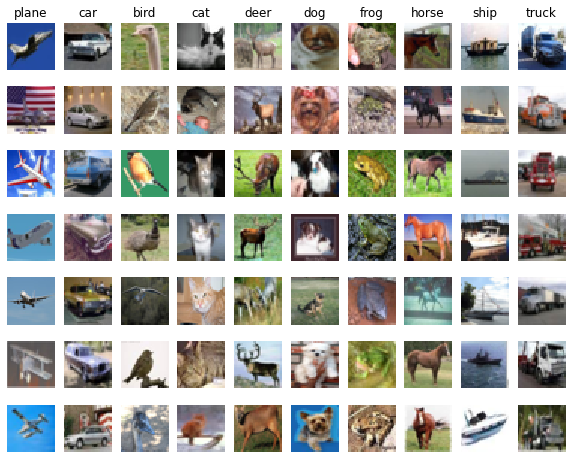

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    #np.random.choice(a, sample수) -> a모집단에서서 sample수 만큼 랜덤으로 뽑기
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [10]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


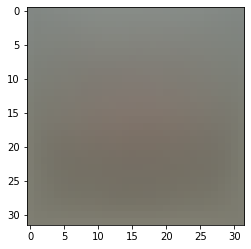

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [11]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.766309


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [31]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.989431 analytic: 1.015143, relative error: 1.282653e-02
numerical: 16.080415 analytic: 16.080415, relative error: 4.479220e-12
numerical: 3.145687 analytic: 3.145687, relative error: 5.864431e-11
numerical: -7.624000 analytic: -7.624000, relative error: 3.892019e-11
numerical: -17.180282 analytic: -17.180282, relative error: 1.409172e-12
numerical: 18.787988 analytic: 18.845013, relative error: 1.515301e-03
numerical: 25.036737 analytic: 25.036737, relative error: 1.088884e-11
numerical: -6.774726 analytic: -6.774726, relative error: 7.013924e-11
numerical: -1.009076 analytic: -0.970584, relative error: 1.944376e-02
numerical: -8.557927 analytic: -8.557927, relative error: 2.421630e-11
numerical: 35.337077 analytic: 35.337077, relative error: 3.624289e-12
numerical: 26.597228 analytic: 26.547944, relative error: 9.273565e-04
numerical: 1.585536 analytic: 1.585536, relative error: 2.270259e-11
numerical: 20.694355 analytic: 20.677917, relative error: 3.973234e-04
numerical:

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  

- Hinge loss는 margin이 0인 지점에서는 미분이 불가능하다. 애초에 gradient가 정의되지 않는 점이므로 임의로 정하는 수 밖에 없다. 구현 코드를 볼 때, margin > 0 일때만 loss를 더해주고 0보다 작거나 같을 때는 더해주지 않는다. 
- 따라서 이때, 예시로,  dMargin/dScore를 구한다고 하자. Score = 2, correct_score = 3이라고 하면 margin = 2-3+1 = 0이다. 그러므로 if문 안에 들어가지 못하기 때문에 gradient를 더해주지 않는다(0이다). 이제 Numerical gradient를 구해보자. h=0.001로 가정하면 gradient는 (0.001-0)/0.001 = 1이 된다. 다음과 같은 차이가 발생하게 된다.
- 이와 같은 상황의 빈도를 줄이기 위해서는 미분이 불가능한 hinge 부분을 멀리 보내어 최대한 만나지 않게 하는 방법이 있다. 그러려면, safety margin을 1이 아닌 훨씬 더 큰 수로 설정하면 된다.

In [17]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.766309e+00 computed in 0.084949s
Vectorized loss: 0.000000e+00 computed in 0.000034s
difference: 8.766309


In [25]:
print(W[0])
print(W.shape[1])

[ 5.56883926e-05  1.39950671e-04  1.03424874e-04  1.87546505e-04
 -7.09278423e-05 -1.35750494e-04 -1.55480641e-04  9.63508472e-05
  2.11005532e-04 -1.42479609e-04]
10


In [26]:
print(X_dev)
print(X_dev.shape)

[[124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [-32.64189796 -48.98173469 -61.47391837 ...  83.13804082  95.60042857
    1.        ]
 [118.35810204 113.01826531 116.52608163 ... 122.13804082 133.60042857
    1.        ]
 ...
 [104.35810204 103.01826531 103.52608163 ... -46.86195918 -37.39957143
    1.        ]
 [ 69.35810204  61.01826531  70.52608163 ...  48.13804082  58.60042857
    1.        ]
 [-43.64189796  17.01826531  74.52608163 ...  46.13804082  96.60042857
    1.        ]]
(500, 3073)


In [51]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.085231s
Vectorized loss and gradient: computed in 0.006327s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [53]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 786.766892
iteration 100 / 1500: loss 286.671114
iteration 200 / 1500: loss 107.526632
iteration 300 / 1500: loss 42.311821
iteration 400 / 1500: loss 18.810043
iteration 500 / 1500: loss 10.441580
iteration 600 / 1500: loss 7.101642
iteration 700 / 1500: loss 6.329143
iteration 800 / 1500: loss 5.239793
iteration 900 / 1500: loss 5.417625
iteration 1000 / 1500: loss 4.729062
iteration 1100 / 1500: loss 5.665036
iteration 1200 / 1500: loss 5.406233
iteration 1300 / 1500: loss 5.574261
iteration 1400 / 1500: loss 5.349584
That took 10.189348s


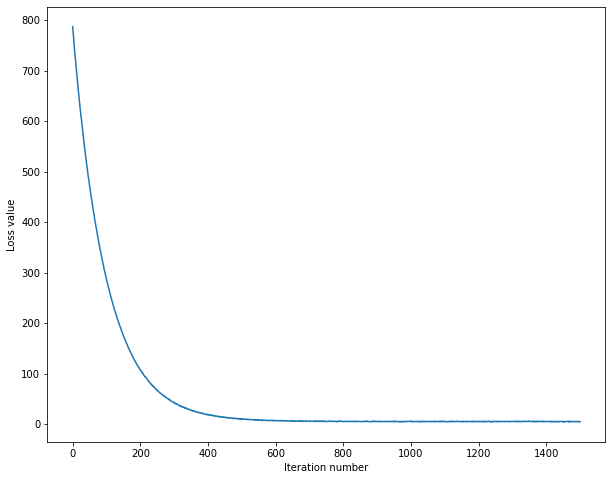

In [54]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [55]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.373041
validation accuracy: 0.371000


In [57]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, lr, reg, num_iters = 800, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_svm = svm
        results[(lr, reg)] = (np.mean(y_train == y_train_pred), val_accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 800: loss 795.744778
iteration 100 / 800: loss 289.080535
iteration 200 / 800: loss 108.230551
iteration 300 / 800: loss 42.707423
iteration 400 / 800: loss 18.535925
iteration 500 / 800: loss 10.438491
iteration 600 / 800: loss 7.422027
iteration 700 / 800: loss 6.414949
iteration 0 / 800: loss 1566.562356
iteration 100 / 800: loss 212.302296
iteration 200 / 800: loss 33.004472
iteration 300 / 800: loss 9.279173
iteration 400 / 800: loss 6.164905
iteration 500 / 800: loss 5.264858
iteration 600 / 800: loss 5.802698
iteration 700 / 800: loss 5.247819
iteration 0 / 800: loss 784.224147
iteration 100 / 800: loss 341481558880484326415597504815393931264.000000
iteration 200 / 800: loss 56444166784055726452341469297754562864670099296695114204620720950279667712.000000
iteration 300 / 800: loss 9329768712521763640945491182358772230508443412992813427825650766008363511949493777770237999365596983637049344.000000
iteration 400 / 800: loss 15421360467976334889017506388722616946477156

/Users/junghwankim/Desktop/cs231n/2022/assignment1/cs231n/classifiers/linear_svm.py:93: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W*W)
/Users/junghwankim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/junghwankim/Desktop/cs231n/2022/assignment1/cs231n/classifiers/linear_svm.py:93: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W*W)


iteration 300 / 800: loss inf
iteration 400 / 800: loss inf
iteration 500 / 800: loss inf


/Users/junghwankim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/junghwankim/Desktop/cs231n/2022/assignment1/cs231n/classifiers/linear_svm.py:118: RuntimeWarning: overflow encountered in multiply
  dW = dW + reg * 2 * W


iteration 600 / 800: loss nan
iteration 700 / 800: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.372082 val accuracy: 0.385000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359449 val accuracy: 0.365000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.056592 val accuracy: 0.057000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.385000


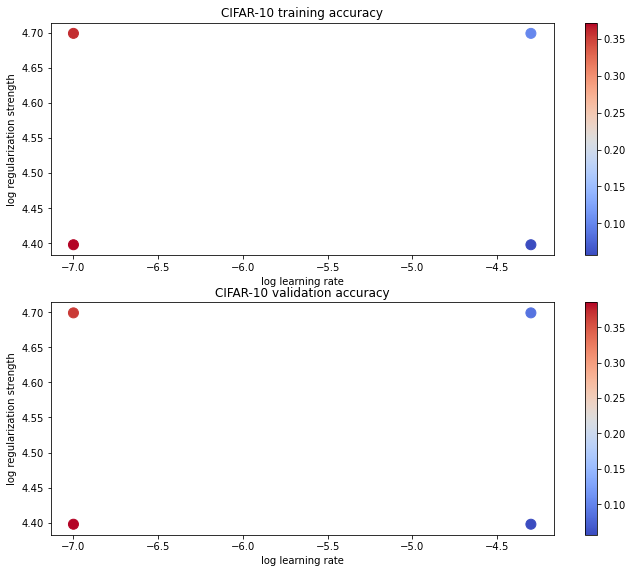

In [58]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [59]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.366000


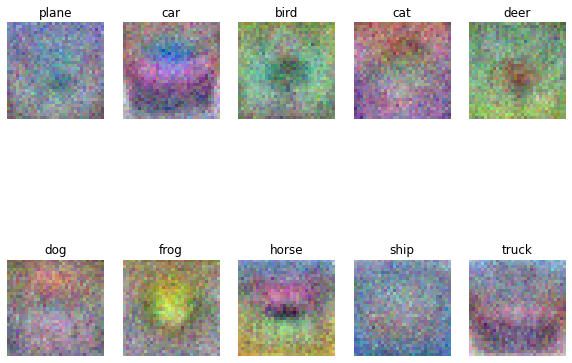

In [60]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  

- 우선, car_W는 car와 곱해진 값이 최대가 되게끔 학습했을것이다.
- 따라서 car와 비슷한 분포로 형성이 되어져서 비슷하게 보이는 것일 것이다.
- 내적의 관점에서 보면, car_W와 car를 내적 연산을 하는데 최대가 되기 위해서는 각이 0에 가까울 수록 내적 값이 최대가 된다. 그리고 다른 벡터와는 내적 시 값을 줄여야 하므로 최대한 W_car와 car의 분포는 비슷하게 형성 되어져야 한다.
